### Reference
[JAX/jraph based GCN by Lisa Wang ](https://colab.research.google.com/github/deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb)

In [ ]:
#!pip install flax
!pip install git+git://github.com/deepmind/jraph.git
!pip install dm-haiku

In [2]:
#import jax.tree_util as tree
#import flax
#import numpy as onp
%matplotlib inline
import functools
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jraph
import haiku as hk
import optax
import pickle
import networkx as nx
from typing import Any, Dict, List, Tuple    # Callable,  Optional,

In [ ]:
!wget -P /tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
with open('/tmp/mutag.pickle', 'rb') as f:
  mutag_ds = pickle.load(f)

In [4]:
len(mutag_ds)                                      # 0=C, 1=N, 2=O, 3=F, 4=I, 5=Cl, 6=Br
# Inspect the first graph
g = mutag_ds[0]['input_graph']
print(f'Number of nodes: {g.n_node[0]}')
print(f'Number of edges: {g.n_edge[0]}')
print(f'Node features shape: {g.nodes.shape}')
print(f'Edge features shape: {g.edges.shape}')
# Target for first graph
print(f"Target: {mutag_ds[0]['target']}")

Number of nodes: 17
Number of edges: 38
Node features shape: (17, 7)
Edge features shape: (38, 4)
Target: [1]


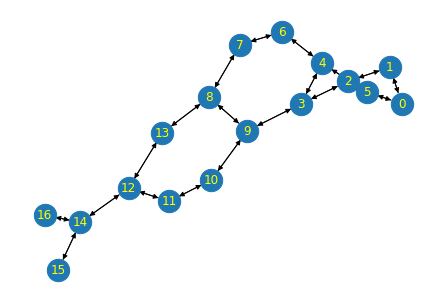

In [6]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

draw_jraph_graph_structure(g)

In [7]:
train_mutag_ds = mutag_ds[:150]
test_mutag_ds = mutag_ds[150:]

In [8]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def _nearest_bigger_power_of_two(x: int) -> int:
  """Computes the nearest power of two greater than x for padding."""
  y = 2
  while y < x:
    y *= 2
  return y

def pad_graph_to_nearest_power_of_two(
    graphs_tuple: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Pads a batched `GraphsTuple` to the nearest power of two.
  For example, if a `GraphsTuple` has 7 nodes, 5 edges and 3 graphs, this method
  would pad the `GraphsTuple` nodes and edges:
    7 nodes --> 8 nodes (2^3)
    5 edges --> 8 edges (2^3)
  And since padding is accomplished using `jraph.pad_with_graphs`, an extra
  graph and node is added:
    8 nodes --> 9 nodes
    3 graphs --> 4 graphs
  Args:
    graphs_tuple: a batched `GraphsTuple` (can be batch size 1).
  Returns:
    A graphs_tuple batched to the nearest power of two.
  """
  # Add 1 since we need at least one padding node for pad_with_graphs.
  pad_nodes_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_node)) + 1
  pad_edges_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_edge))
  # Add 1 since we need at least one padding graph for pad_with_graphs.
  # We do not pad to nearest power of two because the batch size is fixed.
  pad_graphs_to = graphs_tuple.n_node.shape[0] + 1
  return jraph.pad_with_graphs(graphs_tuple, pad_nodes_to, pad_edges_to,
                               pad_graphs_to)

In [9]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
@jraph.concatenated_args
def edge_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Edge update function for graph net."""
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(128)])
  return net(feats)

@jraph.concatenated_args
def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(128)])
  return net(feats)

@jraph.concatenated_args
def update_global_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Global update function for graph net."""
  # MUTAG is a binary classification task, so output pos neg logits.
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(2)])
  return net(feats)

def net_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # Add a global paramater for graph classification.
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
  embedder = jraph.GraphMapFeatures(
      hk.Linear(128), hk.Linear(128), hk.Linear(128))
  net = jraph.GraphNetwork(
      update_node_fn=node_update_fn,
      update_edge_fn=edge_update_fn,
      update_global_fn=update_global_fn)
  return net(embedder(graph))

In [10]:
def compute_loss(params: hk.Params, graph: jraph.GraphsTuple, label: jnp.ndarray,
                 net: jraph.GraphsTuple) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Computes loss and accuracy."""
  pred_graph = net.apply(params, graph)
  preds = jax.nn.log_softmax(pred_graph.globals)
  targets = jax.nn.one_hot(label, 2)

  # Since we have an extra 'dummy' graph in our batch due to padding, we want
  # to mask out any loss associated with the dummy graph.
  # Since we padded with `pad_with_graphs` we can recover the mask by using
  # get_graph_padding_mask.
  mask = jraph.get_graph_padding_mask(pred_graph)

  # Cross entropy loss.
  loss = -jnp.mean(preds * targets * mask[:, None])

  # Accuracy taking into account the mask.
  accuracy = jnp.sum(
      (jnp.argmax(pred_graph.globals, axis=1) == label) * mask) / jnp.sum(mask)
  return loss, accuracy

In [11]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def train(dataset: List[Dict[str, Any]], num_train_steps: int) -> hk.Params:
  """Training loop."""

  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']

  # Initialize the network.
  params = net.init(jax.random.PRNGKey(42), graph)
  # Initialize the optimizer.
  opt_init, opt_update = optax.adam(1e-4)
  opt_state = opt_init(params)

  compute_loss_fn = functools.partial(compute_loss, net=net)
  # We jit the computation of our loss, since this is the main computation.
  # Using jax.jit means that we will use a single accelerator. If you want
  # to use more than 1 accelerator, use jax.pmap. More information can be
  # found in the jax documentation.
  compute_loss_fn = jax.jit(jax.value_and_grad(
      compute_loss_fn, has_aux=True))

  for idx in range(num_train_steps):
    graph = dataset[idx % len(dataset)]['input_graph']
    label = dataset[idx % len(dataset)]['target']
    # Jax will re-jit your graphnet every time a new graph shape is encountered.
    # In the limit, this means a new compilation every training step, which
    # will result in *extremely* slow training. To prevent this, pad each
    # batch of graphs to the nearest power of two. Since jax maintains a cache
    # of compiled programs, the compilation cost is amortized.
    graph = pad_graph_to_nearest_power_of_two(graph)

    # Since padding is implemented with pad_with_graphs, an extra graph has
    # been added to the batch, which means there should be an extra label.
    label = jnp.concatenate([label, jnp.array([0])])

    (loss, acc), grad = compute_loss_fn(params, graph, label)
    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if idx % 50 == 0:
      print(f'step: {idx}, loss: {loss}, acc: {acc}')
  print('Training finished')
  return params

In [12]:
def evaluate(dataset: List[Dict[str, Any]],
             params: hk.Params) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Evaluation Script."""
  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']
  accumulated_loss = 0
  accumulated_accuracy = 0
  compute_loss_fn = jax.jit(functools.partial(compute_loss, net=net))
  for idx in range(len(dataset)):
    graph = dataset[idx]['input_graph']
    label = dataset[idx]['target']
    graph = pad_graph_to_nearest_power_of_two(graph)
    label = jnp.concatenate([label, jnp.array([0])])
    loss, acc = compute_loss_fn(params, graph, label)
    accumulated_accuracy += acc
    accumulated_loss += loss
    if idx % 100 == 0:
      print(f'Evaluated {idx + 1} graphs')
  print('Completed evaluation.')
  loss = accumulated_loss / idx
  accuracy = accumulated_accuracy / idx
  print(f'Eval loss: {loss}, accuracy {accuracy}')
  return loss, accuracy

In [13]:
params = train(train_mutag_ds, num_train_steps=500)

step: 0, loss: 0.2843894958496094, acc: 0.0
step: 50, loss: 0.000632166862487793, acc: 1.0
step: 100, loss: 0.0013380050659179688, acc: 1.0
step: 150, loss: 0.04702794551849365, acc: 1.0
step: 200, loss: 0.041739702224731445, acc: 1.0
step: 250, loss: 0.002824544906616211, acc: 1.0
step: 300, loss: 0.04792594909667969, acc: 1.0
step: 350, loss: 0.03225910663604736, acc: 1.0
step: 400, loss: 0.00306856632232666, acc: 1.0
step: 450, loss: 0.0362280011177063, acc: 1.0
Training finished


In [14]:
evaluate(test_mutag_ds, params)

Evaluated 1 graphs
Completed evaluation.
Eval loss: 0.14461466670036316, accuracy 0.7567567825317383


(DeviceArray(0.14461467, dtype=float32), DeviceArray(0.7567568, dtype=float32))